In [1]:
from db_connection import create_connection
from db_connection import query_data
from db_connection import query_sql_file

from preprocessing import process_admissions

import pandas as pd
import matplotlib.pyplot as plt
import numpy as np

In [2]:
# Connect to the MIMIC-III database
con = create_connection()

# Admissions

In [3]:
query = \
"""
SELECT * FROM admissions;
"""
admissions = query_data(query, con)
print(admissions.head())

C:\Users\Perdorues\Documents\GitHub\comp-1252-explain-deep-learning-models-through-fuzzy-logic\db_connection.py:43: UserWarning: pandas only supports SQLAlchemy connectable (engine/connection) or database string URI or sqlite3 DBAPI2 connection. Other DBAPI2 objects are not tested. Please consider using SQLAlchemy.
  result_df = pd.read_sql_query(query, con)


   row_id  subject_id  hadm_id           admittime           dischtime  \
0      21          22   165315 2196-04-09 12:26:00 2196-04-10 15:54:00   
1      22          23   152223 2153-09-03 07:15:00 2153-09-08 19:10:00   
2      23          23   124321 2157-10-18 19:34:00 2157-10-25 14:00:00   
3      24          24   161859 2139-06-06 16:14:00 2139-06-09 12:48:00   
4      25          25   129635 2160-11-02 02:06:00 2160-11-05 14:55:00   

  deathtime admission_type         admission_location  \
0       NaT      EMERGENCY       EMERGENCY ROOM ADMIT   
1       NaT       ELECTIVE  PHYS REFERRAL/NORMAL DELI   
2       NaT      EMERGENCY  TRANSFER FROM HOSP/EXTRAM   
3       NaT      EMERGENCY  TRANSFER FROM HOSP/EXTRAM   
4       NaT      EMERGENCY       EMERGENCY ROOM ADMIT   

          discharge_location insurance language           religion  \
0  DISC-TRAN CANCER/CHLDRN H   Private     None       UNOBTAINABLE   
1           HOME HEALTH CARE  Medicare     None           CATHOLIC   
2 

In [4]:
print(admissions.info())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 58976 entries, 0 to 58975
Data columns (total 19 columns):
 #   Column                Non-Null Count  Dtype         
---  ------                --------------  -----         
 0   row_id                58976 non-null  int64         
 1   subject_id            58976 non-null  int64         
 2   hadm_id               58976 non-null  int64         
 3   admittime             58976 non-null  datetime64[ns]
 4   dischtime             58976 non-null  datetime64[ns]
 5   deathtime             5854 non-null   datetime64[ns]
 6   admission_type        58976 non-null  object        
 7   admission_location    58976 non-null  object        
 8   discharge_location    58976 non-null  object        
 9   insurance             58976 non-null  object        
 10  language              33644 non-null  object        
 11  religion              58518 non-null  object        
 12  marital_status        48848 non-null  object        
 13  ethnicity       

In [5]:
# check null values
print(admissions.isnull().sum())

row_id                      0
subject_id                  0
hadm_id                     0
admittime                   0
dischtime                   0
deathtime               53122
admission_type              0
admission_location          0
discharge_location          0
insurance                   0
language                25332
religion                  458
marital_status          10128
ethnicity                   0
edregtime               28099
edouttime               28099
diagnosis                  25
hospital_expire_flag        0
has_chartevents_data        0
dtype: int64


In [6]:
# check admission locations
print(admissions.admission_location.value_counts())

EMERGENCY ROOM ADMIT         22754
PHYS REFERRAL/NORMAL DELI    15079
CLINIC REFERRAL/PREMATURE    12032
TRANSFER FROM HOSP/EXTRAM     8456
TRANSFER FROM SKILLED NUR      273
** INFO NOT AVAILABLE **       204
HMO REFERRAL/SICK              102
TRANSFER FROM OTHER HEALT       71
TRSF WITHIN THIS FACILITY        5
Name: admission_location, dtype: int64


In [7]:
# check admission type
print(admissions.admission_type.value_counts())

EMERGENCY    42071
NEWBORN       7863
ELECTIVE      7706
URGENT        1336
Name: admission_type, dtype: int64


In [8]:
admissions = process_admissions.group_admission_type(admissions)
print(admissions.admission_type.value_counts())

EMERGENCY    43407
NEWBORN       7863
ELECTIVE      7706
Name: admission_type, dtype: int64


In [9]:
# check demographics
print(admissions.ethnicity.unique())

['WHITE' 'UNKNOWN/NOT SPECIFIED' 'MULTI RACE ETHNICITY'
 'BLACK/AFRICAN AMERICAN' 'HISPANIC OR LATINO'
 'PATIENT DECLINED TO ANSWER' 'ASIAN' 'OTHER'
 'HISPANIC/LATINO - GUATEMALAN' 'ASIAN - VIETNAMESE'
 'AMERICAN INDIAN/ALASKA NATIVE' 'WHITE - RUSSIAN'
 'HISPANIC/LATINO - PUERTO RICAN' 'ASIAN - CHINESE' 'ASIAN - ASIAN INDIAN'
 'BLACK/AFRICAN' 'HISPANIC/LATINO - SALVADORAN'
 'HISPANIC/LATINO - DOMINICAN' 'UNABLE TO OBTAIN' 'BLACK/CAPE VERDEAN'
 'BLACK/HAITIAN' 'WHITE - OTHER EUROPEAN' 'PORTUGUESE' 'SOUTH AMERICAN'
 'WHITE - EASTERN EUROPEAN' 'CARIBBEAN ISLAND' 'ASIAN - FILIPINO'
 'ASIAN - CAMBODIAN' 'HISPANIC/LATINO - CENTRAL AMERICAN (OTHER)'
 'WHITE - BRAZILIAN' 'ASIAN - KOREAN' 'HISPANIC/LATINO - COLOMBIAN'
 'ASIAN - JAPANESE' 'NATIVE HAWAIIAN OR OTHER PACIFIC ISLANDER'
 'ASIAN - THAI' 'HISPANIC/LATINO - HONDURAN' 'HISPANIC/LATINO - CUBAN'
 'MIDDLE EASTERN' 'ASIAN - OTHER' 'HISPANIC/LATINO - MEXICAN'
 'AMERICAN INDIAN/ALASKA NATIVE FEDERALLY RECOGNIZED TRIBE']


In [10]:
# grouping similar categories
admissions = process_admissions.group_ethnicities(admissions)
print(admissions.ethnicity.value_counts())

WHITE                   41386
OTHER/UNKNOWN            7408
BLACK                    5785
HISPANIC/LATINO          2128
ASIAN                    2050
MULTI RACE ETHNICITY      130
NATIVE AMERICAN            54
ISLANDER                   35
Name: ethnicity, dtype: int64


In [11]:
cross_tab_script = '../sql_scripts/admissions_cross_tab.sql'
query_list = query_sql_file(cross_tab_script, con)

admission_locations = query_data(query_list[0], con)
admission_types = query_data(query_list[1], con)

pivot_table = query_data(query_list[2], con)
print(pivot_table)

          Admission Location ELECTIVE EMERGENCY/URGENT NEWBORN
0   ** INFO NOT AVAILABLE **     None                5     199
1  CLINIC REFERRAL/PREMATURE       25            10002    1987
2       EMERGENCY ROOM ADMIT     None            22754    None
3          HMO REFERRAL/SICK     None                1     101
4  PHYS REFERRAL/NORMAL DELI     7646             1432    5553
5  TRANSFER FROM HOSP/EXTRAM       19              849      23
6  TRANSFER FROM OTHER HEALT        3                7    None
7  TRANSFER FROM SKILLED NUR       13               14    None
8  TRSF WITHIN THIS FACILITY     None                5    None


C:\Users\Perdorues\Documents\GitHub\comp-1252-explain-deep-learning-models-through-fuzzy-logic\db_connection.py:43: UserWarning: pandas only supports SQLAlchemy connectable (engine/connection) or database string URI or sqlite3 DBAPI2 connection. Other DBAPI2 objects are not tested. Please consider using SQLAlchemy.
  result_df = pd.read_sql_query(query, con)
C:\Users\Perdorues\Documents\GitHub\comp-1252-explain-deep-learning-models-through-fuzzy-logic\db_connection.py:43: UserWarning: pandas only supports SQLAlchemy connectable (engine/connection) or database string URI or sqlite3 DBAPI2 connection. Other DBAPI2 objects are not tested. Please consider using SQLAlchemy.
  result_df = pd.read_sql_query(query, con)
C:\Users\Perdorues\Documents\GitHub\comp-1252-explain-deep-learning-models-through-fuzzy-logic\db_connection.py:43: UserWarning: pandas only supports SQLAlchemy connectable (engine/connection) or database string URI or sqlite3 DBAPI2 connection. Other DBAPI2 objects are not tes

In [18]:
# check preliminary diagnosis
print(admissions.diagnosis.unique())

['BENZODIAZEPINE OVERDOSE'
 'CORONARY ARTERY DISEASE\\CORONARY ARTERY BYPASS GRAFT/SDA' 'BRAIN MASS'
 ... 'R/O METASTASIS'
 'GASTROPARESIS\\PLACEMENT OF G-TUBE **REMOTE WEST**/SDA' 'JOINT EFFUSION']


## DIAGNOSES_ICD

In [20]:
query = \
"""
SELECT d1.icd9_code, d2.short_title, COUNT(d1.hadm_id) AS total_admissions
	FROM diagnoses_icd AS d1
	JOIN d_icd_diagnoses AS d2
	ON d1.icd9_code = d2.icd9_code
	GROUP BY d1.icd9_code, d2.short_title;
"""
diagnoses_counts = query_data(query, con)
print(diagnoses_counts)

C:\Users\Perdorues\Documents\GitHub\comp-1252-explain-deep-learning-models-through-fuzzy-logic\db_connection.py:43: UserWarning: pandas only supports SQLAlchemy connectable (engine/connection) or database string URI or sqlite3 DBAPI2 connection. Other DBAPI2 objects are not tested. Please consider using SQLAlchemy.
  result_df = pd.read_sql_query(query, con)


     icd9_code               short_title  total_admissions
0         3897     Deaf, nonspeaking NEC                11
1        78864         Urinary hesitancy                 5
2        58881  Sec hyperparathyrd-renal               169
3        E9444     Adv eff diuretics NEC               123
4         8360  Tear med menisc knee-cur                 5
...        ...                       ...               ...
6836     61802        Cystocele, lateral                 1
6837     90222     Injury hepatic artery                 8
6838      2707  Straig amin-acid met NEC                 3
6839      3453          Grand mal status               248
6840      4779     Allergic rhinitis NOS                47

[6841 rows x 3 columns]


# Patients

In [12]:
query = \
"""
SELECT * FROM patients;
"""
patients = query_data(query, con)
print(patients.head())

C:\Users\Perdorues\Documents\GitHub\comp-1252-explain-deep-learning-models-through-fuzzy-logic\db_connection.py:43: UserWarning: pandas only supports SQLAlchemy connectable (engine/connection) or database string URI or sqlite3 DBAPI2 connection. Other DBAPI2 objects are not tested. Please consider using SQLAlchemy.
  result_df = pd.read_sql_query(query, con)


   row_id  subject_id gender        dob        dod   dod_hosp dod_ssn  \
0     234         249      F 2075-03-13        NaT        NaT     NaT   
1     235         250      F 2164-12-27 2188-11-22 2188-11-22     NaT   
2     236         251      M 2090-03-15        NaT        NaT     NaT   
3     237         252      M 2078-03-06        NaT        NaT     NaT   
4     238         253      F 2089-11-26        NaT        NaT     NaT   

   expire_flag  
0            0  
1            1  
2            0  
3            0  
4            0  


In [13]:
print(patients.info())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 46520 entries, 0 to 46519
Data columns (total 8 columns):
 #   Column       Non-Null Count  Dtype         
---  ------       --------------  -----         
 0   row_id       46520 non-null  int64         
 1   subject_id   46520 non-null  int64         
 2   gender       46520 non-null  object        
 3   dob          46520 non-null  datetime64[ns]
 4   dod          15759 non-null  datetime64[ns]
 5   dod_hosp     9974 non-null   datetime64[ns]
 6   dod_ssn      13378 non-null  datetime64[ns]
 7   expire_flag  46520 non-null  int64         
dtypes: datetime64[ns](4), int64(3), object(1)
memory usage: 2.8+ MB
None


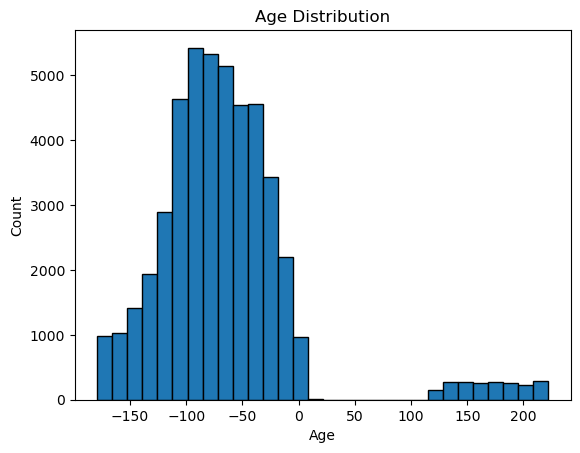

In [14]:
# Visualizing 'AGE' distribution in 'PATIENTS' table
# 'AGE' needs to be calculated based on 'DOB'
patients['age'] = (pd.Timestamp('now') - patients['dob']).dt.days // 365.25
plt.hist(patients['age'], bins=30, edgecolor='black')
plt.xlabel('Age')
plt.ylabel('Count')
plt.title('Age Distribution')
plt.show()